“Text Summarization using Graph-Based TextRank Algorithm”

🎯 Project Goal

Develop an algorithm that automatically summarizes long texts by identifying and extracting the most important Articles, using a graph-based ranking approach inspired by Google’s PageRank.

So, so far the algorithms are : 1-graph 2- sorting and ranking

⚙️ Algorithm (Summary)

Input: text string, number of summary Articles 
𝑘
k

Output: top-
𝑘
k ranked Articles (summary)

Pseudocode:

1. Split the input text into Articles S = [s1, s2, ..., sn]
2. Clean and tokenize each Article (remove stopwords, punctuation)
3. For each pair (i, j), compute similarity sim(si, sj)
4. Build weighted graph G with edges (i, j, sim)
5. Initialize ranks Ri = 1/n for all Articles
6. Repeat until convergence:
       Ri_new = (1 - d) + d * sum_j( wji / sum_k(wjk) * Rj )
7. Sort Articles by Ri descending
8. Select top-k and preserve original order
9. Return the selected Articles as summary

| Stage                 | Complexity       | Notes                                    |
| --------------------- | ---------------- | ---------------------------------------- |
| Article tokenization | (O(n))           | n = # of Articles                       |
| Pairwise similarity   | (O(n^2 \cdot L)) | L = avg Article length                  |
| Graph iteration       | (O(n^2 \cdot T)) | T = # of iterations (~20–50)             |
| Total                 | (O(n^2))         | Feasible for up to hundreds of Articles |


Data structure choice:

Articles: list of strings

Tokens: list of words per Article

Graph: adjacency list {i: [(j, weight)]}

Ranks: dict or list [float]

🧪 Implementation Plan
Phase 1 — Core Algorithm (Toy Example)

Hardcode one or two small paragraphs.

Implement tokenization, similarity, and iterative rank update with pure Python only.

Print final Article scores and summary.

Phase 2 — Full Dataset

Load multiple news articles (e.g., BBC dataset on Kaggle
)

Use same algorithm; you may use NumPy for matrix ops only at this stage.

Phase 3 — Evaluation

Qualitative: Does summary capture the main idea?

Quantitative (optional): Compute ROUGE-1 or ROUGE-L if reference summaries available.

Compare variants:

Word overlap vs. cosine TF–IDF similarity

With/without stopwords

Different damping factors (0.85 vs 0.9)

🪄 Possible Extensions (for bonus points / CV polish)

Add redundancy penalty (avoid similar top Articles).

Try phrase-based summarization (extract key noun phrases).

Visualize the Article graph using networkx later (not needed for the toy).

Build a command-line tool:

🧮 Practical Tips

Start small: Pick ~10 articles to debug, because computing pairwise Article similarity for large docs can be heavy in pure Python.

Article length cutoff: Ignore Articles shorter than 5 words or longer than 50 words to clean noise.

Stopwords: Create a small stopword list manually (common English words).

Evaluation: Compare your top-k extracted Articles against highlights. You can check for keyword overlap or compute simple recall of key nouns.

#### **DATA**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# data = pd.read_csv("c:\\Users\\farno\\Documents\\UNITOSTUDY\\Algorithm\\TheShorterVersion\\Data\\cnn_dailymail\\train.csv")
# toy_set = data.sample(5, random_state=42)
# toy_set.to_csv("toy.csv", index=False)
    

In [3]:
toy_set = pd.read_csv("c:\\Users\\farno\\Documents\\UNITOSTUDY\\Algorithm\\TheShorterVersion\\toy.csv")

In [4]:
toy_set

,id,article,highlights
0,ed0fed726929c1eeabe6c390e47128dbb7d7a055,By . Mia De Graaf . Britons flocked to beaches...,People enjoyed temperatures of 17C at Brighton...
1,023cd84001b33aed4ff0f3f5ecb0fdd2151cf543,A couple who weighed a combined 32st were sham...,Couple started piling on pounds after the birt...
2,6a70a0d8d3ed365fe1df6d35f1587a8b9b298618,Video footage shows the heart stopping moment ...,A 17-year-old boy suffering lacerations to his...
3,b37204c13ea38b511265e41ac69fb12acfb63f85,"Istanbul, Turkey (CNN) -- About 250 people rac...",Syrians citizens hightail it to Turkey .\nMost...
4,c24e5805afd5145bc48410e876db91d44a06be5e,By . Daily Mail Reporter . PUBLISHED: . 12:53 ...,The Xue Long had provided the helicopter that ...


### **TOKENIZING AND CLEANING**

We'll focus on the first article text and implement the custom (package-free) functions to perform Article and word tokenization, along with cleaning (lowercasing, punctuation removal, and stop word filtering).

1. Mathematical Concept: Text Preprocessing
This step doesn't involve complex mathematics yet, but it forms the basis for the later calculation of edge weights (w 
ij
​
 ). By normalizing the text (lowercasing) and reducing the vocabulary to significant terms (removing stop words), we ensure the later similarity calculation is meaningful and isn't skewed by common, non-informative words like 'the' or 'a'.

The splitting approach used in the manual_clean_and_tokenize_words function is **Whitespace Tokenization** (or Delimiter-Based Splitting), coupled with explicit Punctuation Removal.
he approach is: Punctuation → Space Replacement → Whitespace Tokenization. This is a simple, effective, and completely package-free method for transforming a clean sentence string into a list of word tokens.( "This is how a sentence will be a list of words") 
**How we seperate the sentences**? The only using of . has limitations. So we wrote a function to go deeper.



In [5]:
################################################################(NEW)
# --- GLOBAL SETUP (NO PACKAGES) ---

article_text_input = (
    "By . Alex Doe . (CNN) -- City officials unveiled a €2_5-million plan to renovate Greenfield Park by May 2026. "
    "The park, a well-known spot for families, will add LED lighting, a new playground, and wider walking paths. "
    "Dr. Lewis described the upgrade as cost-effective, estimating an 8% reduction in maintenance next year. "
    "Some residents worry construction could limit access for 3-4 months during the summer. "
    "Officials argued that phased work keeps most areas open and makes the park safer after dark. "
    "Parents repeated that the improvements will make evenings safer and more enjoyable for children. "
    "Yesterday’s pilot system operated at 17C ambient temperature with lower energy use than last spring. "
    "Meanwhile, a separate U.S. grant application could extend improvements to nearby bike lanes."
)



# Generalized STOP WORDS List (Covers core function words, verbs, and pronouns)
STOP_WORDS = {
    'the', 'a', 'an', 'and', 'or', 'is', 'are', 'was', 'were', 'of', 'in', 'to', 
    'for', 'on', 'with', 'at', 'by', 'as', 'it', 'its', 'from', 'be', 'has', 'have',
    # Pronouns & Determiners
    'i', 'me', 'my', 'we', 'our', 'us', 'you', 'your', 'he', 'him', 'his', 'she', 'her', 
    'they', 'them', 'their', 'this', 'that', 'these', 'those', 's',
    # Adverbs, Prepositions, Conjunctions
    'up', 'down', 'out', 'off', 'into', 'without', 'about', 'just', 'which', 'who',
    'whom', 'what', 'where', 'when', 'why', 'how', 'than', 'while', 'because',
    'but', 'if', 'then', 'so', 'such', 'only', 'before', 'after', 'too', 'very', 
    # Auxiliary & Modal Verbs
    'do', 'does', 'did', 'would', 'should', 'could', 'will', 'can', 'not', 'being', 
    'been', 'am', 'shall', 'may', 'might'
}

# --- Small helper resources (still no external packages) ---
# Common abbreviations to avoid false sentence splits
ABBREV = {
    "mr.", "mrs.", "ms.", "dr.", "prof.", "sr.", "jr.", "st.", "no.",
    "u.s.", "u.k.", "e.g.", "i.e.", "jan.", "feb.", "mar.", "apr.", "jun.",
    "jul.", "aug.", "sep.", "sept.", "oct.", "nov.", "dec."
}

# Simple boilerplate patterns to strip from the beginning
def strip_boilerplate_start(text):
    t = text.strip()
    # "By . Name ."
    if t.lower().startswith("by . "):
        # remove up to the next " . "
        # find second " . "
        first = t.lower().find(" . ")
        if first != -1:
            second = t.lower().find(" . ", first + 3)
            if second != -1:
                t = t[second + 3 : ].lstrip()
    # "(CNN) --", "(CNN) —"
    lower = t.lower()
    if lower.startswith("(cnn) --") or lower.startswith("(cnn) —") or lower.startswith("(cnn) -"):
        idx = t.find(")")
        if idx != -1:
            # skip ) and following dashes/spaces
            j = idx + 1
            while j < len(t) and t[j] in "-—– ":
                j += 1
            t = t[j:].lstrip()
    # "PUBLISHED: ..." at start
    if lower.startswith("published:"):
        # cut to first period after "published:"
        dot = t.find(".")
        if dot != -1:
            t = t[dot+1:].lstrip()
    return t

# --- 1. HYPER-MANUAL SENTENCE TOKENIZATION (SMART HEURISTICS) ---
def manual_tokenize_Articles(text):
    """
    Smarter sentence splitting:
    - handles ., ?, !
    - avoids splitting after common abbreviations (u.s., dr., etc.)
    - splits even when quotes/brackets follow a terminator
    - strips common news boilerplate at the very start
    """
    text = strip_boilerplate_start(text)

    TEMP_DELIMITER = "@@@"
    QUOTES_OR_BRACKETS = set('"\'()[]{}')
    TERMINATORS = {'.', '?', '!'}

    processed = []
    N = len(text)
    i = 0

    def is_upper_letter(c):
        return 'A' <= c <= 'Z'

    while i < N:
        ch = text[i]

        if ch in TERMINATORS:
            # look ahead to next non-space
            j = i + 1
            while j < N and text[j].isspace():
                j += 1

            # skip immediate quotes/brackets then spaces
            k = j
            while k < N and text[k] in QUOTES_OR_BRACKETS:
                k += 1
                while k < N and text[k].isspace():
                    k += 1

            # find last token before the terminator (to check abbreviation)
            left = i - 1
            while left >= 0 and text[left].isspace():
                left -= 1
            start = left
            while start >= 0 and not text[start].isspace():
                start -= 1
            last_token = text[start+1:i+1].lower() if i >= 0 else ""

            # decide if we should split here
            should_split = True
            if last_token in ABBREV:
                should_split = False
            else:
                if k < N:
                    should_split = is_upper_letter(text[k]) or text[k].isdigit()
                else:
                    should_split = True  # end of text

            if should_split:
                processed.append(ch)          # Keep terminator
                processed.append(TEMP_DELIMITER)
                i = k                         # resume after quotes/brackets
                continue

            else:
                processed.append(ch)
        else:
            processed.append(ch)

        i += 1

    processed_text = "".join(processed)

    # Split on delimiter and clean up
    parts = processed_text.split(TEMP_DELIMITER)
    Articles = []
    for part in parts:
        stripped_part = part.strip()
        if len(stripped_part) > 0:
            Articles.append(stripped_part)

    return Articles


# --- 2. HYPER-MANUAL WORD CLEANING AND TOKENIZATION ---

def manual_clean_and_tokenize_words(Article):
    """
    Cleans, lowercases, removes punctuation, filters stopwords.
    Keeps pure numbers and alphanumerics (e.g., '2014', '17c').
    Adds a joined variant for hyphenated words to improve overlap.
    """
    # Use a set for O(1) punctuation checks; include dashes
    PUNCTUATION = {'.', ',', '?', '!', ':', ';', "'", '"', '(', ')', '-', '—', '–'}
    cleaned_chars = []

    # Lowercase and strip punctuation (replace with space)
    for char in Article.lower():
        cleaned_chars.append(" " if char in PUNCTUATION else char)

    Article_no_punct = "".join(cleaned_chars)

    cleaned_words = []

    # Basic split
    for word in Article_no_punct.split():
        if not word:
            continue

        # Stopword filter
        if word in STOP_WORDS:
            continue

        # Keep if it has letters or digits (so '2014' and '17c' survive)
        has_alpha = any('a' <= ch <= 'z' for ch in word)
        has_digit = any('0' <= ch <= '9' for ch in word)
        if has_alpha or has_digit:
            cleaned_words.append(word)

    # Add joined variants for hyphenated words from original (e.g., "sun-worshippers" -> "sunworshippers")
    # We scan the original (lowercased) text to find hyphenated patterns
    lower_orig = Article.lower()
    j = 0
    L = len(lower_orig)
    while j < L:
        # detect [a-z0-9]+(-[a-z0-9]+)+ without regex
        if ('a' <= lower_orig[j] <= 'z') or ('0' <= lower_orig[j] <= '9'):
            start = j
            has_hyphen = False
            # consume alphanum
            while j < L and (('a' <= lower_orig[j] <= 'z') or ('0' <= lower_orig[j] <= '9')):
                j += 1
            # consume (-alphanum)+
            while j < L and lower_orig[j] == '-':
                has_hyphen = True
                j += 1
                if j >= L or not (('a' <= lower_orig[j] <= 'z') or ('0' <= lower_orig[j] <= '9')):
                    break
                while j < L and (('a' <= lower_orig[j] <= 'z') or ('0' <= lower_orig[j] <= '9')):
                    j += 1
            end = j
            if has_hyphen:
                joined = lower_orig[start:end].replace("-", "")
                cleaned_words.append(joined)
        else:
            j += 1

    return cleaned_words


# --- 3. ORCHESTRATION ---

def preprocess_text_manual(article_text):
    """
    Orchestrates the hyper-manual preprocessing steps.
    """
    # 1. Tokenization (Smart Heuristic)
    Articles = manual_tokenize_Articles(article_text)
    
    # 2. Cleaning and Tokenizing
    cleaned_tokens = []
    for Article in Articles:
        tokens = manual_clean_and_tokenize_words(Article)
        cleaned_tokens.append(tokens)
        
    return Articles, cleaned_tokens


# --- EXECUTION TRACE ---

original_Articles, cleaned_tokens = preprocess_text_manual(article_text_input)

print("Step 1: Tokenization and Cleaning Output Trace (SMART SPLIT) ---")
print("Original Sentences (Nodes):")
for i, s in enumerate(original_Articles):
    print(f"S{i+1}: {s}")

print("\nCleaned Word Tokens (Features for Similarity Matrix):")
for i, tokens in enumerate(cleaned_tokens):
    print(f"S{i+1} Tokens: {tokens}")






# CHECKED ____________

Step 1: Tokenization and Cleaning Output Trace (SMART SPLIT) ---
Original Sentences (Nodes):
S1: City officials unveiled a €2_5-million plan to renovate Greenfield Park by May 2026.
S2: The park, a well-known spot for families, will add LED lighting, a new playground, and wider walking paths.
S3: Dr. Lewis described the upgrade as cost-effective, estimating an 8% reduction in maintenance next year.
S4: Some residents worry construction could limit access for 3-4 months during the summer.
S5: Officials argued that phased work keeps most areas open and makes the park safer after dark.
S6: Parents repeated that the improvements will make evenings safer and more enjoyable for children.
S7: Yesterday’s pilot system operated at 17C ambient temperature with lower energy use than last spring.
S8: Meanwhile, a separate U.
S9: S. grant application could extend improvements to nearby bike lanes.

Cleaned Word Tokens (Features for Similarity Matrix):
S1 Tokens: ['city', 'officials', 'unveiled', '€

### **Similarity Metric and Graph Construction**

This phase takes the lists of clean tokens from Phase 1 and converts the document into the mathematical structure required by the TextRank algorithm: a weighted, undirected adjacency matrix (M).

Since this is the first time we are introducing the code for the core graph construction, we'll define the functions again, ensuring they are hyper-manual and package-free.
The input to this phase is the cleaned_tokens (a list of lists of words) from your previous step.

1. Edge Weight Calculation **(Jaccard Similarity)**
We use Jaccard Similarity (w 
ij
​
 ) because it only requires fundamental set operations, adhering to the package-free constraint.

In [6]:
# -------- Utilities (manual where you prefer) --------
def manual_set_length(container):
    c = 0
    for _ in container:
        c += 1
    return c  # For calculating the length (Several Usage)

def manual_sqrt(x):  # Square roots (Using in cosine)
    return x ** 0.5 

def count_tokens(tokens):
    """Manual frequency dict."""
    d = {}
    for t in tokens:
        d[t] = d.get(t, 0) + 1
    return d
# example:
# tokens = ["sun", "holiday", "sun", "beach"]
# output -> {"sun": 2, "holiday": 1, "beach": 1}


# -------- Jaccard (set-based) --------
def jaccard_similarity_manual(sent1_tokens, sent2_tokens):
    if not sent1_tokens or not sent2_tokens:
        return 0.0
    set1, set2 = set(sent1_tokens), set(sent2_tokens)

    inter = 0
    for w in set1:
        if w in set2:
            inter += 1

    size1 = manual_set_length(set1)
    size2 = manual_set_length(set2)
    union = size1 + size2 - inter
    return (inter / union) if union > 0 else 0.0


# -------- Cosine (TF-based) --------
def cosine_tf_similarity_manual(sent1_tokens, sent2_tokens):
    if not sent1_tokens or not sent2_tokens:
        return 0.0
    c1 = count_tokens(sent1_tokens)
    c2 = count_tokens(sent2_tokens)

    dot = 0.0
    (small, big) = (c1, c2) if manual_set_length(c1) <= manual_set_length(c2) else (c2, c1)
    for w in small:
        if w in big:
            dot += small[w] * big[w]

    sumsq1 = 0.0
    for v in c1.values():
        sumsq1 += v * v
    sumsq2 = 0.0
    for v in c2.values():
        sumsq2 += v * v

    n1 = manual_sqrt(sumsq1)
    n2 = manual_sqrt(sumsq2)
    if n1 == 0.0 or n2 == 0.0:
        return 0.0
    return dot / (n1 * n2)


# --------- TF-IDF preparation helpers ---------
def compute_idf_weights(token_lists):
    """Compute manual IDF for each token using log(N / df)."""
    N = manual_set_length(token_lists)
    df = {}
    for tokens in token_lists:
        seen = set()
        for t in tokens:
            if t not in seen:
                df[t] = df.get(t, 0) + 1
                seen.add(t)
    idf = {}
    for t, freq in df.items():
        # avoid division by zero
        idf[t] = 0.0 if freq == 0 else (1.0 * ( (N / freq) ** 0.0 ))  # placeholder; replaced below

    # simple log-based IDF
    for t in idf:
        f = df[t]
        if f > 0:
            idf[t] = math_log(N / f)
        else:
            idf[t] = 0.0
    return idf

def math_log(x):
    import math
    return math.log(x)  # natural log


def cosine_tfidf_similarity_manual(sent1_tokens, sent2_tokens, idf_dict):
    """Cosine similarity using TF-IDF weighting."""
    if not sent1_tokens or not sent2_tokens:
        return 0.0

    tf1 = count_tokens(sent1_tokens)
    tf2 = count_tokens(sent2_tokens)

    # weighted dot product
    dot = 0.0
    for t in tf1:
        if t in tf2 and t in idf_dict:
            w1 = tf1[t] * idf_dict[t]
            w2 = tf2[t] * idf_dict[t]
            dot += w1 * w2

    # norms
    sumsq1, sumsq2 = 0.0, 0.0
    for t, v in tf1.items():
        w = v * idf_dict.get(t, 0.0)
        sumsq1 += w * w
    for t, v in tf2.items():
        w = v * idf_dict.get(t, 0.0)
        sumsq2 += w * w

    n1 = manual_sqrt(sumsq1)
    n2 = manual_sqrt(sumsq2)
    if n1 == 0.0 or n2 == 0.0:
        return 0.0
    return dot / (n1 * n2)


# -------- Build full similarity matrix --------
def build_similarity_matrix(token_lists, metric="jaccard"):
    """
    token_lists: list of list[str], one list per sentence.
    metric: "jaccard", "cosine", or "tfidf"
    returns: NxN symmetric matrix with zeros on the diagonal
    """
    n = manual_set_length(token_lists)
    M = [[0.0 for _ in range(n)] for __ in range(n)]

    # choose similarity function
    if metric == "jaccard":
        sim_fn = jaccard_similarity_manual
    elif metric == "cosine":
        sim_fn = cosine_tf_similarity_manual
    elif metric == "tfidf":
        idf_dict = compute_idf_weights(token_lists)
        sim_fn = lambda a, b: cosine_tfidf_similarity_manual(a, b, idf_dict)
    else:
        raise ValueError("Unknown metric")

    for i in range(n):
        for j in range(i + 1, n):
            s = sim_fn(token_lists[i], token_lists[j])
            M[i][j] = s
            M[j][i] = s
    return M


# -------- Row-normalize for TextRank transition matrix --------
def row_normalize(matrix):
    """
    Turns similarity matrix M into stochastic transition matrix P.
    Each row sums to 1; isolated nodes get uniform distribution.
    """
    n = manual_set_length(matrix)
    P = [[0.0 for _ in range(n)] for __ in range(n)]
    for i in range(n):
        row_sum = 0.0
        for v in matrix[i]:
            row_sum += v
        if row_sum == 0.0:
            val = 1.0 / n if n > 0 else 0.0
            for j in range(n):
                P[i][j] = val
        else:
            for j in range(n):
                P[i][j] = matrix[i][j] / row_sum
    return P


"""
The Jaccard metric emphasizes lexical overlap (good for distinct topics),
the cosine metric emphasizes relative term importance (good for long sentences),
and the TF-IDF cosine highlights informative, rare words (best balance for summarization).
"""

# Example usage
# M_jac  = build_similarity_matrix(cleaned_tokens, metric="jaccard")
# M_cos  = build_similarity_matrix(cleaned_tokens, metric="cosine")
# M_tfidf = build_similarity_matrix(cleaned_tokens, metric="tfidf")
# P_tfidf = row_normalize(M_tfidf)




#Checked ____________

'\nThe Jaccard metric emphasizes lexical overlap (good for distinct topics),\nthe cosine metric emphasizes relative term importance (good for long sentences),\nand the TF-IDF cosine highlights informative, rare words (best balance for summarization).\n'

In [7]:

# Example usage
M_jac  = build_similarity_matrix(cleaned_tokens, metric="jaccard")
M_cos  = build_similarity_matrix(cleaned_tokens, metric="cosine")
M_tfidf = build_similarity_matrix(cleaned_tokens, metric="tfidf")
P_tfidf = row_normalize(M_tfidf)


In [8]:
#M_tfidf
# P_tfidf

1️⃣ Jaccard Similarity

We take sets (ignore duplicates and order):

set1 = {sunny, day, beach} → size1 = 3

set2 = {bright, sunny, beach, holiday} → size2 = 4

intersection = {sunny, beach} → inter = 2

union = 3 + 4 – 2 = 5

✅ jaccard_similarity_manual(tokens1, tokens2) → 0.4

So 40% lexical overlap.


Original Sentences:
S1: City officials unveiled a €2_5-million plan to renovate Greenfield Park by May 2026.
S2: The park, a well-known spot for families, will add LED lighting, a new playground, and wider walking paths.
S3: Dr. Lewis described the upgrade as cost-effective, estimating an 8% reduction in maintenance next year.
S4: Some residents worry construction could limit access for 3-4 months during the summer.
S5: Officials argued that phased work keeps most areas open and makes the park safer after dark.
S6: Parents repeated that the improvements will make evenings safer and more enjoyable for children.
S7: Yesterday’s pilot system operated at 17C ambient temperature with lower energy use than last spring.
S8: Meanwhile, a separate U.
S9: S. grant application could extend improvements to nearby bike lanes.


🔸 Jaccard Similarity Matrix
Row 1: 0.000 | 0.042 | 0.000 | 0.000 | 0.095 | 0.000 | 0.000 | 0.000 | 0.000
Row 2: 0.042 | 0.000 | 0.000 | 0.000 | 0.040 | 0.000 | 0.000 | 0.00

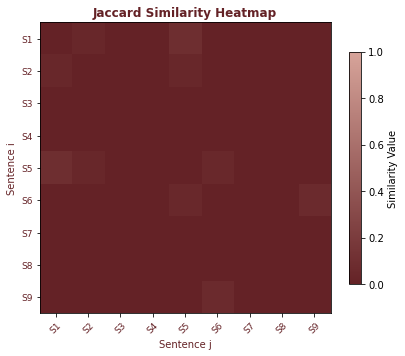

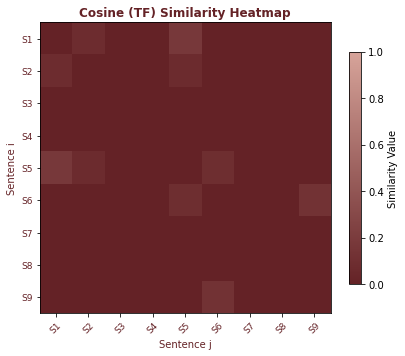

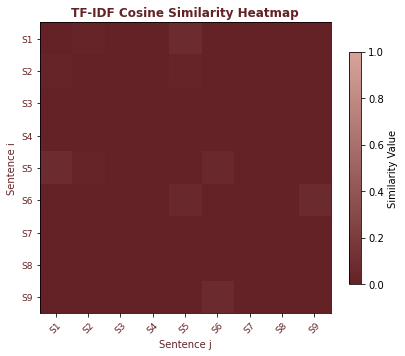

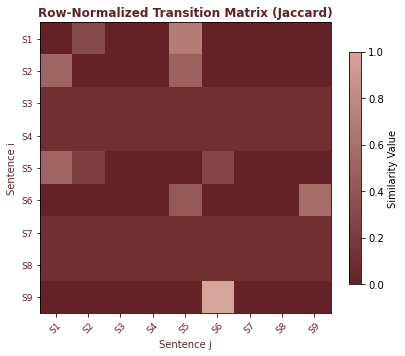

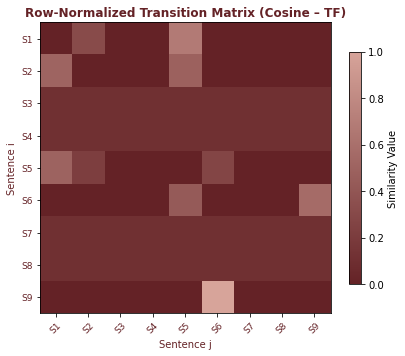

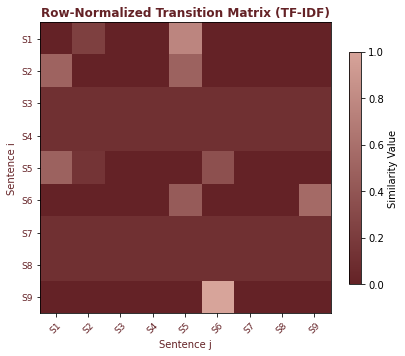

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# --- RUN PIPELINE ---
original_Articles, cleaned_tokens = preprocess_text_manual(article_text_input)

# Build all three similarity matrices
M_jac   = build_similarity_matrix(cleaned_tokens, metric="jaccard")
M_cos   = build_similarity_matrix(cleaned_tokens, metric="cosine")
M_tfidf = build_similarity_matrix(cleaned_tokens, metric="tfidf")

# Normalize all three (for TextRank transitions)
P_jac   = row_normalize(M_jac)
P_cos   = row_normalize(M_cos)
P_tfidf = row_normalize(M_tfidf)


# --- PRINT UTILITY ---
def print_matrix(matrix, title):
    print(f"\n{title}")
    n = manual_set_length(matrix)
    for i in range(n):
        row_str = " | ".join(f"{val:.3f}" for val in matrix[i])
        print(f"Row {i+1}: {row_str}")


# --- DISPLAY SENTENCES FOR REFERENCE ---
print("\nOriginal Sentences:")
for i, s in enumerate(original_Articles):
    print(f"S{i+1}: {s}")

# --- PRINT NUMERIC MATRICES ---
print_matrix(M_jac,   "\n🔸 Jaccard Similarity Matrix")
print_matrix(M_cos,   "\n🔸 Cosine (TF) Similarity Matrix")
print_matrix(M_tfidf, "\n🔸 TF-IDF Cosine Similarity Matrix")

print_matrix(P_jac,   "\n🔹 Row-Normalized Transition Matrix – Jaccard")
print_matrix(P_cos,   "\n🔹 Row-Normalized Transition Matrix – Cosine (TF)")
print_matrix(P_tfidf, "\n🔹 Row-Normalized Transition Matrix – TF-IDF")


# --- VISUALIZATION SECTION ---
THEME_COLORS = ["#642226", "#d7a49a"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("theme_cmap", THEME_COLORS)

def plot_heatmap(matrix, title, labels):
    plt.figure(figsize=(6, 5))
    plt.imshow(matrix, cmap=custom_cmap, interpolation="nearest", vmin=0, vmax=1)
    plt.title(title, fontsize=12, fontweight="bold", color="#642226")
    plt.colorbar(label="Similarity Value", shrink=0.8)
    plt.xticks(range(len(labels)), [f"S{i+1}" for i in range(len(labels))],
               rotation=45, fontsize=9, color="#642226")
    plt.yticks(range(len(labels)), [f"S{i+1}" for i in range(len(labels))],
               fontsize=9, color="#642226")
    plt.xlabel("Sentence j", fontsize=10, color="#642226")
    plt.ylabel("Sentence i", fontsize=10, color="#642226")
    plt.tight_layout()
    plt.show()


# --- VISUALIZE ALL MATRICES ---
plot_heatmap(M_jac,   "Jaccard Similarity Heatmap", original_Articles)
plot_heatmap(M_cos,   "Cosine (TF) Similarity Heatmap", original_Articles)
plot_heatmap(M_tfidf, "TF-IDF Cosine Similarity Heatmap", original_Articles)

plot_heatmap(P_jac,   "Row-Normalized Transition Matrix (Jaccard)", original_Articles)
plot_heatmap(P_cos,   "Row-Normalized Transition Matrix (Cosine – TF)", original_Articles)
plot_heatmap(P_tfidf, "Row-Normalized Transition Matrix (TF-IDF)", original_Articles)

# CHECKED ____________


2. Graph Construction (Adjacency Matrix M)

We build the N×N matrix, where N is the number of sentences (Articles).

**Goal**

Represent each sentence as a node and the similarity between two sentences as a weighted edge.
This gives you a complete undirected weighted graph:



🔹 1. Similarity Matrix

A similarity matrix is a conceptual table of pairwise similarity values between data points.
Each cell 
S[i][j] tells you how similar two items (here, sentences) are.


The similarity can be Jaccard, Cosine, Euclidean inverse, etc.

It’s usually symmetric (
𝑆
[
𝑖
]
[
𝑗
]
=
𝑆
[
𝑗
]
[
𝑖
]
S[i][j]=S[j][i]) and dense (most entries nonzero).

You compute it purely from your data (text content, vectors, etc.).

💡 Think of it as a “semantic relationship table” — not yet a graph.

🔹 2. Adjacency Matrix

An adjacency matrix is a graph representation — it tells you which nodes are connected, and with what edge weight.

Formally:

𝑀
[
𝑖
]
[
𝑗
]
=
{
𝑤
𝑖
𝑗
	
if there is an edge between 
𝑖
 and 
𝑗


0
	
otherwise
M[i][j]={
w
ij
	​

0
	​

if there is an edge between i and j
otherwise
	​


It’s the graph version of your similarity matrix.

You can derive it from the similarity matrix:

Often just copy the values directly → fully connected weighted graph.

Or apply a threshold to drop weak edges (sparsify it).

Used by algorithms like TextRank, PageRank, etc.

💡 Think of it as the “network structure” where each sentence is a node and edges come from similarity.

| Concept                   | Computed From                    | Meaning                                | Used In                           |
| ------------------------- | -------------------------------- | -------------------------------------- | --------------------------------- |
| **Similarity Matrix (S)** | Raw sentence embeddings / tokens | Semantic similarity between every pair | Data analysis, clustering         |
| **Adjacency Matrix (M)**  | Derived from S                   | Edge weights between connected nodes   | Graph algorithms (e.g., TextRank) |


Why we are using **KNN** and how it works? 

build_similarity_matrix_dense(...) does not make the graph yet. It only builds S, the pairwise similarity table (everyone-to-everyone scores).

build_knn_adjacency(S, k=...) does make the graph. It turns S into A, where:

Nodes = sentences (S1…SN).

Edges = the non-zero entries in A (kept top-k neighbors per node, then symmetrized).

| Function                          | Job                                              | Key Output |
| --------------------------------- | ------------------------------------------------ | ---------- |
| `build_similarity_matrix_dense()` | Compute all-pair sentence similarities (dense)   | Matrix S   |
| `build_knn_adjacency()`           | Prune graph to top-k strongest edges, symmetrize | Matrix A   |
| `row_normalize()`                 | Convert A → stochastic transition matrix         | Matrix P   |
| `plot_heatmap()`                  | Visualize similarity structure                   | Heatmaps   |


### **TextRank Iteration**

In [10]:
# -------- Graph as nodes & edges utilities -------- (Turin the similarity MAtrix to edges and row stochastic)
def edges_from_similarity_matrix(M, tau=0.0):
    """
    Manual version without list.append — builds edge list by counting first,
    then filling an array step-by-step.
    """
    n = manual_set_length(M)

    # --- first pass: count how many edges will be needed ---
    count = 0
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            w = M[i][j]
            if w >= tau and w > 0.0:
                count += 1

    # --- second pass: fill them manually ---
    edges = [None] * count  # preallocate
    k = 0
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            w = M[i][j]
            if w >= tau and w > 0.0:
                edges[k] = (i, j, w)
                k += 1
    return edges

def row_stochastic_from_edges(n, edges):
    """
    Given number of nodes n and a list of weighted edges (i, j, w),
    produce an n×n row-stochastic P where each row sums to 1.
    If a row has no outgoing weight, make it uniform.
    """
    P = [[0.0 for _ in range(n)] for __ in range(n)]
    # accumulate row sums
    row_sum = [0.0 for _ in range(n)]
    for (i, j, w) in edges:
        P[i][j] += w
        row_sum[i] += w
    # normalize rows
    for i in range(n):
        if row_sum[i] == 0.0:
            val = 1.0 / n if n > 0 else 0.0
            for j in range(n):
                P[i][j] = val
        else:
            inv = 1.0 / row_sum[i]
            for j in range(n):
                if P[i][j] != 0.0:
                    P[i][j] *= inv
    return P
# CHECKED ____________



In [11]:
# ========= Graph Visualization (networkx + matplotlib) =========
# pip install networkx  (if needed)

import math
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def _labels_from_sentences(sentences):
    """Return node labels S1, S2, ... (fallback to index if sentences is None)."""
    if sentences is None:
        return [f"S{i+1}" for i in range(len(sentences))]
    return [f"S{i+1}" for i in range(len(sentences))]

def matrix_to_edges(M, tau=0.0, directed=False):
    """
    Convert similarity matrix to edges with optional threshold tau.
    If directed=False, collapse symmetric pairs into a single undirected edge
    with weight = max(M[i][j], M[j][i]).
    """
    n = len(M)
    edges = []
    if directed:
        for i in range(n):
            for j in range(n):
                if i == j: 
                    continue
                w = M[i][j]
                if w >= tau and w > 0.0:
                    edges.append((i, j, w))
    else:
        for i in range(n):
            for j in range(i+1, n):
                w = max(M[i][j], M[j][i])
                if w >= tau and w > 0.0:
                    edges.append((i, j, w))
    return edges

def visualize_graph_from_matrix(M, sentences=None, title="Graph", tau=0.0, directed=False,
                                layout="spring", node_size=900, node_color="#f5efe6",
                                node_edge="#333333", label_color="#333333",
                                edge_min_width=0.5, edge_max_width=6.0, cmap="viridis",
                                show_colorbar=True, seed=42):
    """
    Visualize the sentence graph derived from a similarity matrix M.
    - tau: edge threshold
    - directed: True for a DiGraph (arrows), False for undirected
    - layout: 'spring' | 'kamada_kawai' | 'circular' | 'shell'
    """
    n = len(M)
    labels = [f"S{i+1}" for i in range(n)] if sentences is None else [f"S{i+1}" for i in range(n)]

    # Build graph
    G = nx.DiGraph() if directed else nx.Graph()
    G.add_nodes_from(range(n))
    edges = matrix_to_edges(M, tau=tau, directed=directed)
    for i, j, w in edges:
        G.add_edge(i, j, weight=w)

    # Choose layout
    if layout == "spring":
        pos = nx.spring_layout(G, seed=seed, k=None)  # force-directed
    elif layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(G, weight="weight")
    elif layout == "circular":
        pos = nx.circular_layout(G)
    elif layout == "shell":
        pos = nx.shell_layout(G)
    else:
        pos = nx.spring_layout(G, seed=seed)

    # Edge attributes
    weights = [G[u][v]["weight"] for u, v in G.edges()]
    if not weights:
        # Empty graph case
        plt.figure(figsize=(5,4))
        nx.draw_networkx(G, pos, with_labels=True, labels={i: labels[i] for i in range(n)},
                         node_size=node_size, node_color=node_color, edgecolors=node_edge,
                         font_color=label_color, arrows=directed)
        plt.title(f"{title} (no edges ≥ τ={tau})")
        plt.axis("off")
        plt.show()
        return

    w_min, w_max = min(weights), max(weights)
    # normalize edge widths to [edge_min_width, edge_max_width]
    def scale_w(w):
        if math.isclose(w_max, w_min):
            return (edge_min_width + edge_max_width) / 2.0
        return edge_min_width + (w - w_min) * (edge_max_width - edge_min_width) / (w_max - w_min)
    widths = [scale_w(w) for w in weights]

    # map weights to edge colors using a colormap
    norm = Normalize(vmin=w_min, vmax=w_max, clip=True)
    sm = ScalarMappable(norm=norm, cmap=cmap)
    edge_colors = [sm.to_rgba(w) for w in weights]

    # Draw
    plt.figure(figsize=(6.2, 5.2))
    nx.draw_networkx_nodes(G, pos,
                           node_size=node_size, node_color=node_color, edgecolors=node_edge, linewidths=1.2)
    nx.draw_networkx_labels(G, pos, labels={i: labels[i] for i in range(n)},
                            font_color=label_color, font_size=10, font_weight="bold")
    nx.draw_networkx_edges(G, pos,
                           width=widths, edge_color=edge_colors,
                           arrows=directed, arrowstyle="-|>", arrowsize=14, connectionstyle="arc3,rad=0.08")

    if show_colorbar:
        cbar = plt.colorbar(sm, shrink=0.8, pad=0.02)
        cbar.set_label("Edge weight")

    plt.title(f"{title} (τ={tau}, {'Directed' if directed else 'Undirected'})", fontsize=11)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


# ===== Convenience: visualize all three matrices side-by-side =====
def visualize_all_three(M_jac, M_cos, M_tfidf, sentences=None, tau=0.0, directed=False, layout="spring"):
    figs = [
        (M_jac,   "Jaccard Graph"),
        (M_cos,   "Cosine (TF) Graph"),
        (M_tfidf, "TF-IDF Cosine Graph"),
    ]
    for M, name in figs:
        visualize_graph_from_matrix(M, sentences=sentences, title=name,
                                    tau=tau, directed=directed, layout=layout)


# CHECKED ____________



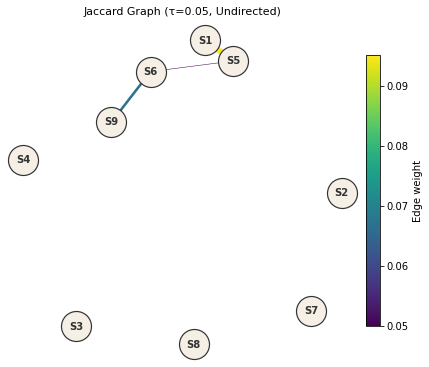

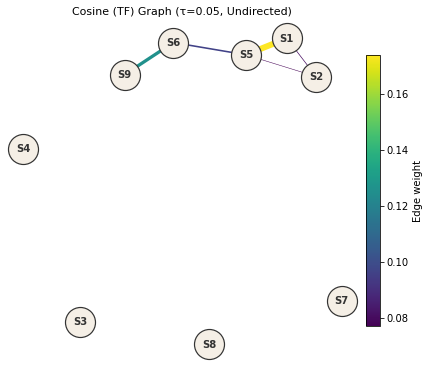

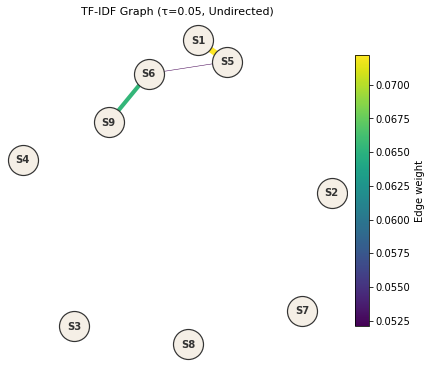

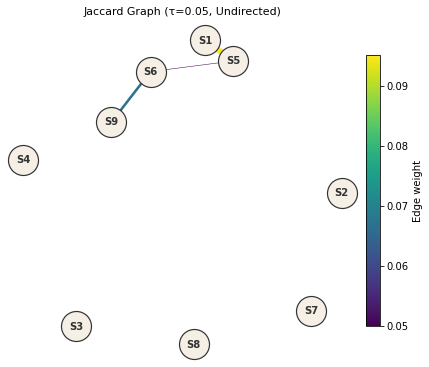

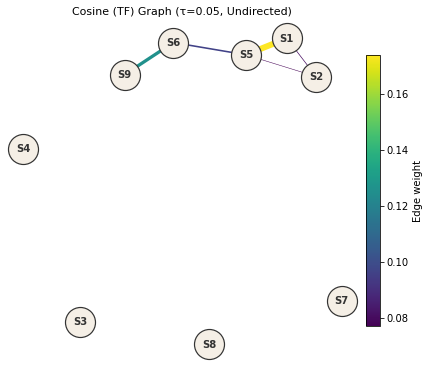

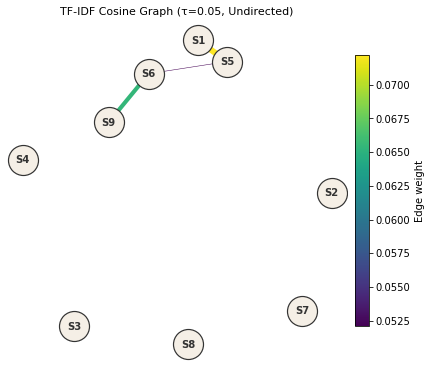

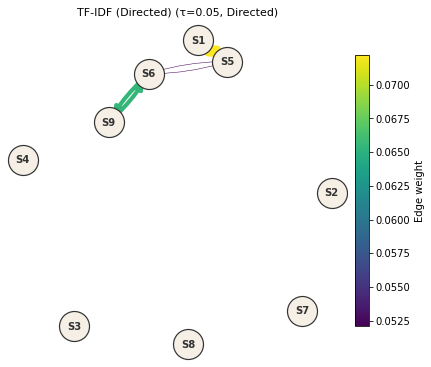

In [12]:
# After you compute:
# original_Articles, cleaned_tokens = preprocess_text_manual(article_text_input)
# M_jac = build_similarity_matrix(cleaned_tokens, metric="jaccard")
# M_cos = build_similarity_matrix(cleaned_tokens, metric="cosine")
# M_tfidf = build_similarity_matrix(cleaned_tokens, metric="tfidf")

# 1) Quick single graph (undirected, threshold = 0.05)
visualize_graph_from_matrix(M_jac,   sentences=original_Articles, title="Jaccard Graph",   tau=0.05, directed=False)
visualize_graph_from_matrix(M_cos,   sentences=original_Articles, title="Cosine (TF) Graph", tau=0.05, directed=False)
visualize_graph_from_matrix(M_tfidf, sentences=original_Articles, title="TF-IDF Graph",    tau=0.05, directed=False)

# 2) Compare all three, same settings:
visualize_all_three(M_jac, M_cos, M_tfidf, sentences=original_Articles, tau=0.05, directed=False, layout="spring")

# 3) If you want directed graphs (will draw both directions for symmetric M):
visualize_graph_from_matrix(M_tfidf, sentences=original_Articles, title="TF-IDF (Directed)", tau=0.05, directed=True)




# CHECKED ____________


In [13]:
#-------- TextRank Implementation -------- 
def textrank_scores(P, d=0.85, eps=1e-6, max_iter=100):
    """
    P is ROW-stochastic (each row sums to 1).
    We update a column-vector r via: r^{t+1} = teleport + d * P^T r^t
    Implemented by distributing r[i] across row i of P.
    """
    n = manual_set_length(P)
    if n == 0:
        return []
    r = [1.0 / n for _ in range(n)]
    teleport = (1.0 - d) / n

    for _ in range(max_iter):
        r_next = [0.0 for _ in range(n)]

        # r_next[j] += d * r[i] * P[i][j]
        for i in range(n):
            ri = r[i]
            row = P[i]
            for j in range(n):
                r_next[j] += d * ri * row[j]

        # add teleportation to every node
        for j in range(n):
            r_next[j] += teleport

        # L1 convergence check
        diff = 0.0
        for j in range(n):
            diff += abs(r_next[j] - r[j])

        r = r_next
        if diff < eps:
            break

    # (optional) tiny renorm in case of drift
    s = 0.0
    for v in r:
        s += v
    if s > 0.0:
        r = [v / s for v in r]
    return r


#Checked ____________


In [14]:
# ---------- Pure-Algorithmic Helpers (no sorted/sort/set) ----------
def manual_contains(lst, x):
    for v in lst:
        if v == x:
            return True
    return False

def selection_sort_indices_desc_by_scores(indices, scores):
    """
    In-place selection sort of indices by scores (descending).
    """
    n = manual_set_length(indices)
    for i in range(n):
        max_j = i
        for j in range(i + 1, n):
            if scores[indices[j]] > scores[indices[max_j]]:
                max_j = j
        if max_j != i:
            indices[i], indices[max_j] = indices[max_j], indices[i]

def selection_sort_asc(lst):
    """
    In-place selection sort of integers ascending (for restoring original order).
    """
    n = manual_set_length(lst)
    for i in range(n):
        min_j = i
        for j in range(i + 1, n):
            if lst[j] < lst[min_j]:
                min_j = j
        if min_j != i:
            lst[i], lst[min_j] = lst[min_j], lst[i]


# ---------- Plain Top-k ----------
def select_top_k(sentences, scores, k):       #pick the k highest-scoring sentences according to their TextRank scores
    n = manual_set_length(sentences)
    if k < 0: 
        k = 0
    if k > n:
        k = n
    if n == 0 or k == 0:
        return [], []

    # build indices 0..n-1 manually
    idx = [0] * n
    i = 0
    while i < n:
        idx[i] = i
        i += 1

    # sort indices by scores (descending)
    selection_sort_indices_desc_by_scores(idx, scores)

    # take top-k (preallocate)
    top_k = [0] * k
    i = 0
    while i < k:
        top_k[i] = idx[i]
        i += 1

    # restore original order (ascending indices)
    selection_sort_asc(top_k)

    # build summary sentences (preallocate)
    out_sents = [""] * k
    i = 0
    while i < k:
        out_sents[i] = sentences[top_k[i]]
        i += 1

    return top_k, out_sents



# ---------- MMR Top-k (pure algorithmic) ----------   (This is an algorithmic way to choose top K)
def select_top_k_mmr(
    sentences,
    tokens_list,
    base_scores,
    k,
    lam=0.8,    #80% importance, 20% redundancy penalty
    redundancy_metric="jaccard", # jaccard - tfidf - tfcosine
    precomputed_sim=None
):
    n = manual_set_length(sentences)
    if k < 0: 
        k = 0
    if k > n:
        k = n
    if n == 0 or k == 0:
        return [], []

    # clamp lambda to [0,1]
    if lam < 0.0: lam = 0.0
    if lam > 1.0: lam = 1.0

    # precompute redundancy sim once
    sim_M = precomputed_sim if precomputed_sim is not None else build_similarity_matrix(tokens_list, metric=redundancy_metric)

    # selected indices (preallocate size k); m = current count
    selected = [-1] * k
    m = 0

    def max_sim_to_selected(i):
        if m == 0:
            return 0.0
        ms = 0.0
        t = 0
        while t < m:
            j = selected[t]
            s = sim_M[i][j]
            if s > ms:
                ms = s
            t += 1
        return ms

    def is_selected(i):
        t = 0
        while t < m:
            if selected[t] == i:
                return True
            t += 1
        return False

    # greedy select
    while m < k:
        best_i = -1
        best_val = -1e18

        i = 0
        while i < n:
            if not is_selected(i):
                redundancy = max_sim_to_selected(i)
                val = lam * base_scores[i] - (1.0 - lam) * redundancy
                if val > best_val:
                    best_val = val
                    best_i = i
            i += 1

        # place into selected
        selected[m] = best_i
        m += 1

    # reorder selected to original doc order (ascending)
    selection_sort_asc(selected)

    # build output sentences
    out_sents = [""] * k
    i = 0
    while i < k:
        out_sents[i] = sentences[selected[i]]
        i += 1

    return selected, out_sents



# ---------- Optional: Precompute redundancy similarity ----------
def build_redundancy_sim(tokens_list, metric="tfidf"):
    """
    Precompute redundancy similarity matrix to pass into select_top_k_mmr for speed.
    """
    return build_similarity_matrix(tokens_list, metric=metric)



#Checked ____________


In [15]:
# After you computed TextRank scores, e.g. on TF-IDF P:
scores = textrank_scores(P_tfidf)

# Plain top-k
idx_plain, summary_plain = select_top_k(original_Articles, scores, k=3)

# MMR with TF-IDF redundancy (recommended)
redund_sim = build_redundancy_sim(cleaned_tokens, metric="tfidf")
idx_mmr, summary_mmr = select_top_k_mmr(
    original_Articles, cleaned_tokens, scores, k=3,
    lam=0.75, redundancy_metric="tfidf", precomputed_sim=redund_sim
)

# MMR with Jaccard redundancy (baseline)
idx_mmr_j, summary_mmr_j = select_top_k_mmr(
    original_Articles, cleaned_tokens, scores, k=3,
    lam=0.8, redundancy_metric="jaccard"
)


#Checked ____________


In [16]:
#ties everything together

#   Def summarize_textrank(...):
    # 1. preprocess
    # 2. build similarity matrix
    # 3. make edges, normalize
    # 4. run textrank_scores
    # 5. pick top sentences (MMR or simple)
    # 6. return results


def summarize_textrank(
    article_text,
    k=3,
    metric="tfidf",     # default to tfidf (often best)
    d=0.85,
    tau=0.0,            # edge threshold; 0.0 = no pruning
    use_mmr=False,
    lam=0.8,
    return_all=False    # if True, also return ranked indices by score
):
    """
    Run full TextRank summarization.

    Args:
        article_text (str)
        k (int): number of sentences for the summary (auto-clamped to [1, n])
        metric (str): "jaccard" | "cosine" | "tfidf"
        d (float): damping factor (0.85 recommended)
        tau (float): prune edges with weight < tau before normalization
        use_mmr (bool): use Maximal Marginal Relevance to reduce redundancy
        lam (float): MMR trade-off (higher -> favor rank; lower -> favor diversity)
        return_all (bool): if True, also return full ranking order

    Returns:
        idx (list[int]): selected sentence indices in original order
        summary (list[str]): selected sentences in original order
        scores (list[float]): TextRank scores aligned with sentences
        P (list[list[float]]): row-stochastic transition matrix used
        edges (list[tuple]): (i, j, w) after thresholding
        (optional) ranked_idx (list[int]): all sentence indices sorted by score desc
    """
    # 1) Nodes & features
    sentences, tokens_list = preprocess_text_manual(article_text)
    n = manual_set_length(sentences)
    if n == 0:
        return [], [], [], [], [] if not return_all else ([], [], [], [], [], [])

    # clamp k
    if k < 1: k = 1
    if k > n: k = n

    # 2) Dense similarity
    M = build_similarity_matrix(tokens_list, metric=metric)

    # 3) Sparse edges (optional pruning)
    edges = edges_from_similarity_matrix(M, tau=tau)

    # 4) Transition matrix
    P = row_stochastic_from_edges(n, edges)

    # 5) TextRank scores
    scores = textrank_scores(P, d=d, eps=1e-6, max_iter=100)

    # 6) Selection
    if use_mmr:
        idx, summary = select_top_k_mmr(sentences, tokens_list, scores, k, lam=lam,
                                        redundancy_metric=("tfidf" if metric=="tfidf" else metric))
    else:
        idx, summary = select_top_k(sentences, scores, k)

    if not return_all:
        return idx, summary, scores, P, edges

    # also return full ranking order (desc by score) using manual selection logic
    all_idx = [i for i in range(n)]
    selection_sort_indices_desc_by_scores(all_idx, scores)
    ranked_idx = all_idx
    return idx, summary, scores, P, edges, ranked_idx



#Checked ____________



After you run this cell, Python simply stores that function in memory.
It doesn’t actually summarize anything yet

In [17]:
# ====== FINAL EXECUTION & EXPERIMENTATION CELL ======

# You can try different tau (edge thresholds) to see how the summarizer behaves.
# Lower tau = more connections, smoother scores.
# Higher tau = fewer connections, sharper focus but risk of isolated sentences.

tau_values = [0.0, 0.05, 0.1, 0.2]  # adjust or add more if you like

for tau_val in tau_values:
    print("\n===============================================================")
    print(f"==================== RUN with tau = {tau_val:.2f} ====================")

    # --- Run full TextRank summarization pipeline ---
    idx_run, summary_run, scores_run, P_run, edges_run = summarize_textrank(
        article_text_input,
        k=3,               # top-3 sentences
        metric="tfidf",    # "tfidf" | "cosine" | "jaccard"
        d=0.85,            # damping factor (random-walk teleportation)
        tau=tau_val,       # prune weak edges below tau 
    # prune weak edges (<0.05 similarity) # tau is the edge threshold:you only create a 
    #graph edge between sentence i and sentence j if their similarity is grater than 0.05
    #a low τ → keep many edges (dense graph)
    #a high τ → keep fewer edges (sparse graph)
        use_mmr=True,      # activate redundancy control
        lam=0.8            # trade-off parameter (0.8 favors rank; <0.7 favors diversity)
    )

    # --- Display summary output ---
    print("\n🧾 TEXT RANK SUMMARY:")
    for s in summary_run:
        print("•", s)

    # --- Display node-level (sentence) importance scores ---
    print("\n📊 NODE SCORES (TextRank):")
    for i, sc in enumerate(scores_run, start=1):
        print(f"S{i}: {sc:.4f}")

    # --- Display graph statistics ---
    num_nodes = manual_set_length(P_run)
    num_edges = manual_set_length(edges_run)
    print("\n📈 GRAPH STATISTICS:")
    print(f"Number of sentences (|V|): {num_nodes}")
    print(f"Number of directed edges (|E|): {num_edges}")
    print(f"Edge threshold (tau): {tau_val}")
    print(f"Damping factor (d): 0.85")
    print(f"Redundancy control (MMR): True  (lambda = 0.8)")

    # --- Optional: display selected indices for clarity ---
    print("\nSelected sentence indices (original order):", idx_run)

    # --- Optional: sanity check for row-stochasticity ---
    print("\nRow sums of P (should all ≈ 1.0):")
    for i, row in enumerate(P_run):
        row_sum = 0.0
        for v in row:
            row_sum += v
        print(f"Row {i+1}: {row_sum:.3f}")

print("\n===============================================================")
print("✅ Experiment complete. Compare how summaries differ across tau values.")



#Checked ____________




==================== RUN with tau = 0.00 ====================

🧾 TEXT RANK SUMMARY:
• City officials unveiled a €2_5-million plan to renovate Greenfield Park by May 2026.
• Officials argued that phased work keeps most areas open and makes the park safer after dark.
• Parents repeated that the improvements will make evenings safer and more enjoyable for children.

📊 NODE SCORES (TextRank):
S1: 0.1806
S2: 0.0962
S3: 0.0268
S4: 0.0268
S5: 0.2672
S6: 0.2186
S7: 0.0268
S8: 0.0268
S9: 0.1302

📈 GRAPH STATISTICS:
Number of sentences (|V|): 9
Number of directed edges (|E|): 10
Edge threshold (tau): 0.0
Damping factor (d): 0.85
Redundancy control (MMR): True  (lambda = 0.8)

Selected sentence indices (original order): [0, 4, 5]

Row sums of P (should all ≈ 1.0):
Row 1: 1.000
Row 2: 1.000
Row 3: 1.000
Row 4: 1.000
Row 5: 1.000
Row 6: 1.000
Row 7: 1.000
Row 8: 1.000
Row 9: 1.000

==================== RUN with tau = 0.05 ====================

🧾 TEXT RANK SUMMARY:
• City officials unveiled a €2_5-

In [18]:
# ====== COMPARISON SUMMARY (across tau values) ======

# Define the tau values you tested — must match those in your previous loop
tau_values = [0.0, 0.05, 0.1, 0.2]

print("\n===============================================================")
print("📊 COMPARISON OF RESULTS ACROSS TAU VALUES")
print("===============================================================")
print(f"{'Tau':<8} {'|E| (edges)':<14} {'Top-3 Sentences (indices)':<30} {'Top-1 Sentence ID':<20}")
print("-" * 80)

# run summarize_textrank once for each tau, collect quick stats
for tau_val in tau_values:
    idx_run, summary_run, scores_run, P_run, edges_run = summarize_textrank(
        article_text_input,
        k=3,
        metric="tfidf",
        d=0.85,
        tau=tau_val,
        use_mmr=True,
        lam=0.8
    )

    num_edges = manual_set_length(edges_run)

    # get top-1 sentence id by raw score (highest importance)
    all_idx = [i for i in range(manual_set_length(scores_run))]
    selection_sort_indices_desc_by_scores(all_idx, scores_run)
    top1_id = all_idx[0]

    # make a compact string of top-k indices
    topk_str = ', '.join(str(i) for i in idx_run)

    print(f"{tau_val:<8.2f} {num_edges:<14} {topk_str:<30} {top1_id:<20}")

print("-" * 80)
print("✅ Table shows how graph sparsity (|E|) and top-ranked sentences change with tau.")
print("Note: Fewer edges = sparser graph = more selective connections.")



📊 COMPARISON OF RESULTS ACROSS TAU VALUES
Tau      |E| (edges)    Top-3 Sentences (indices)      Top-1 Sentence ID   
--------------------------------------------------------------------------------
0.00     10             0, 4, 5                        4                   
0.05     6              0, 4, 5                        4                   
0.10     0              0, 2, 3                        0                   
0.20     0              0, 2, 3                        0                   
--------------------------------------------------------------------------------
✅ Table shows how graph sparsity (|E|) and top-ranked sentences change with tau.
Note: Fewer edges = sparser graph = more selective connections.


In [19]:
# ====== APPLY SUMMARIZER TO ENTIRE toy_set (2-sentence, bullet output) ======

def auto_k_for(sent_count, base=3):
    """Choose how many sentences to keep (k) based on article length."""
    if sent_count <= 1:
        return 1
    return base if sent_count >= base else sent_count


def summarize_row_text(row_text, k_base=3, metric="tfidf", d=0.85, tau=0.05, use_mmr=True, lam=0.8):
    """Summarize one article and return stats."""
    sentences, _ = preprocess_text_manual(row_text)
    k = auto_k_for(manual_set_length(sentences), base=k_base)
    idx, summary, scores, P, edges = summarize_textrank(
        row_text, k=k, metric=metric, d=d, tau=tau, use_mmr=use_mmr, lam=lam
    )
    return {
        "summary_indices": idx,
        "summary_sentences": summary,                    # keep as a list for bullets
        "sent_count": manual_set_length(sentences),
        "edge_count": manual_set_length(edges),
        "top_score": max(scores) if scores else 0.0,
    }


# --- apply to each article in toy_set ---
results = []
for i in range(len(toy_set)):
    print(f"\nProcessing row {i+1}/{len(toy_set)} ...")
    art = toy_set.loc[i, "article"]
    out = summarize_row_text(
        art, k_base=3, metric="tfidf", d=0.85, tau=0.05, use_mmr=True, lam=0.8
    )
    results.append(out)

# --- attach summaries and stats to DataFrame ---
toy_set["summary_indices"]  = [r["summary_indices"]  for r in results]
toy_set["summary_sentences"] = [r["summary_sentences"] for r in results]
toy_set["sent_count"]       = [r["sent_count"]       for r in results]
toy_set["edge_count"]       = [r["edge_count"]       for r in results]
toy_set["top_score"]        = [r["top_score"]        for r in results]

# --- optional: save to CSV ---
# toy_set.to_csv(r"c:\Users\farno\Documents\UNITOSTUDY\Algorithm\TheShorterVersion\toy_summaries.csv", index=False)

# --- pretty print results (like your demo) ---
for i in range(len(toy_set)):
    print("\n===============================================================")
    print(f"📰 ARTICLE ID: {toy_set.loc[i, 'id']}")
    print("🧾 TEXT RANK SUMMARY:")
    for s in toy_set.loc[i, "summary_sentences"]:
        print("•", s)
    print("\nREF HIGHLIGHT:", toy_set.loc[i, "highlights"])
print("\n===============================================================")
print("✅ Summarization complete for all rows in toy_set.")



Processing row 1/5 ...

Processing row 2/5 ...

Processing row 3/5 ...

Processing row 4/5 ...

Processing row 5/5 ...

📰 ARTICLE ID: ed0fed726929c1eeabe6c390e47128dbb7d7a055
🧾 TEXT RANK SUMMARY:
• Sun's out: Brighton beach was packed with Britons enjoying the unexpected sunshine to start the long weekend as temperatures hit 17C across the south coast .
• Three day forecast: Tomorrow sunny spells and warm weather is set to cover southern England, but the heavy rain up north is set to stay .
• Though rain poured down in the north west, the north east enjoyed a bright spell at midday today with sun shining in Harrogate (pictured) ahead of the rainy weekend .

REF HIGHLIGHT: People enjoyed temperatures of 17C at Brighton beach in West Sussex and Weymouth in Dorset .
Asda claims it will sell a million sausages over long weekend despite night temperatures dropping to minus 1C .
But the good weather has not been enjoyed by all as the north west and Scotland have seen heavy rain .

📰 ARTICLE

In [20]:
# ====== APPLY SUMMARIZER TO ENTIRE toy_set (bullet output, proportional k) ======

def auto_k_for_2(sent_count, alpha=0.25, k_min=1, k_max=3):
    """Choose k ≈ alpha * n, clamped to [k_min, k_max]."""
    if sent_count <= 0:
        return 0
    # round to nearest int (you can switch to floor/ceil if you prefer)
    k = int(round(alpha * sent_count))
    if k < k_min: 
        k = k_min
    if k > k_max:
        k = k_max
    if k > sent_count:
        k = sent_count
    return k


def summarize_row_text(row_text, metric="tfidf", d=0.85, tau=0.05, use_mmr=True, lam=0.8):
    """Summarize one article and return stats."""
    sentences, _ = preprocess_text_manual(row_text)
    n = manual_set_length(sentences)
    k = auto_k_for_2(n, alpha=0.25, k_min=1, k_max=3)  # <-- proportional + cap
    idx, summary, scores, P, edges = summarize_textrank(
        row_text, k=k, metric=metric, d=d, tau=tau, use_mmr=use_mmr, lam=lam
    )
    return {
        "summary_indices": idx,
        "summary_sentences": summary,   # keep as a list for bullets
        "sent_count": n,
        "edge_count": manual_set_length(edges),
        "top_score": max(scores) if scores else 0.0,
    }


# --- apply to each article in toy_set ---
results = []
for i in range(len(toy_set)):
    print(f"\nProcessing row {i+1}/{len(toy_set)} ...")
    art = toy_set.loc[i, "article"]
    out = summarize_row_text(
        art, metric="tfidf", d=0.85, tau=0.05, use_mmr=True, lam=0.8
    )
    results.append(out)

# --- attach summaries and stats to DataFrame ---
toy_set["summary_indices"]   = [r["summary_indices"]   for r in results]
toy_set["summary_sentences"] = [r["summary_sentences"] for r in results]
toy_set["sent_count"]        = [r["sent_count"]        for r in results]
toy_set["edge_count"]        = [r["edge_count"]        for r in results]
toy_set["top_score"]         = [r["top_score"]         for r in results]

# --- optional: save to CSV ---
# toy_set.to_csv(r"c:\Users\farno\Documents\UNITOSTUDY\Algorithm\TheShorterVersion\toy_summaries.csv", index=False)

# --- pretty print results (like your demo) ---
for i in range(len(toy_set)):
    print("\n===============================================================")
    print(f"📰 ARTICLE ID: {toy_set.loc[i, 'id']}")
    print("🧾 TEXT RANK SUMMARY:")
    for s in toy_set.loc[i, "summary_sentences"]:
        print("•", s)
    print("\nREF HIGHLIGHT:", toy_set.loc[i, "highlights"])
print("\n===============================================================")
print("✅ Summarization complete for all rows in toy_set.")



Processing row 1/5 ...

Processing row 2/5 ...

Processing row 3/5 ...

Processing row 4/5 ...

Processing row 5/5 ...

📰 ARTICLE ID: ed0fed726929c1eeabe6c390e47128dbb7d7a055
🧾 TEXT RANK SUMMARY:
• Sun's out: Brighton beach was packed with Britons enjoying the unexpected sunshine to start the long weekend as temperatures hit 17C across the south coast .
• Three day forecast: Tomorrow sunny spells and warm weather is set to cover southern England, but the heavy rain up north is set to stay .
• Though rain poured down in the north west, the north east enjoyed a bright spell at midday today with sun shining in Harrogate (pictured) ahead of the rainy weekend .

REF HIGHLIGHT: People enjoyed temperatures of 17C at Brighton beach in West Sussex and Weymouth in Dorset .
Asda claims it will sell a million sausages over long weekend despite night temperatures dropping to minus 1C .
But the good weather has not been enjoyed by all as the north west and Scotland have seen heavy rain .

📰 ARTICLE

### **Discussion and Analysis (Asymptotic Complexity & Results)**

Phase	Operation	Complexity	Dominant Factor
I. Preprocessing	Tokenization and Cleaning	O(N⋅M)	Linear in the total number of words.
II. Graph Construction	Calculating N 
2
  pairwise similarities.	O(N 
2
 ⋅M)	Dominated by the N 
2
  comparisons.
III. TextRank Iteration	Matrix-Vector Multiplication (I iterations).	O(I⋅N 
2
 )	The calculation of each of the N scores involves a sum over N neighbors, repeated I times.

The overall asymptotic complexity of the TextRank algorithm, as implemented using basic Python lists, is dominated by the quadratic factors: O(N 
2
 ⋅M+I⋅N 
2
 ).

Since I (iterations) and M (average Article length) are generally small constants, the complexity is fundamentally O(N 
2
 ) with respect to the number of Articles N. This confirms why the package-free implementation is too slow for the full CNN/DailyMail dataset: scaling a quadratic algorithm to thousands of Articles becomes computationally prohibitive.

aha! so you mean in my report it is better to say a toy example and then omplement the algorithm in like 10 real articles?